## 3D Printed Tube Transition Piece Example
- A "Turtle Graphics" approach is used to define the extrusion paths:  A series of `(segment length, change of heading angle)` - tuples defines a path segment. e.g. the tuple `(2*pi ,2*pi)` defines a unit circle, the tuple `(1,0)` a straight line of unit length, and `(0,-30*deg)` turns on the spot `30deg` to the right.
- Print layers are defined as a list of path offsets and extrusion widths:  Each layer has a different `(offset,extrusion width)`-list defined. The result is a "Brickwork" of overlapping extrusions.
- Complex numbers are used for the 2D coordinates:  2D translations and rotations are simple additions and multiplications of complex numbers. E.g. the complex expression `(3+5j)*1j**(30/90)` rotates the point `(x=3,y=5)` counter-clockwise by `30deg` around the origin.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign
deg=pi/180 #conversion from degrees to radians

def mirrorTurtlePath(turtlePath):
    "This function returns the original path with its mirror image appended to it."
    return turtlePath+turtlePath[-1::-1]
    
def polygonArea(p):
  "This function calculates the length of a the perimeter, and the enclosed area of an arbitrary polygon.\n"
  "The 2D points have to be passed as an numpy array of complex values (e.g. (x=5,y=3) -> 5+3j )"
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def turtlePathLengthArea(turtlePath):
  "This function calculates the length of a path and the enclosed area. \n"
  "The path has to be defined as a list of arc segments: [(length, heading angle change in radians),..]"
  nSegs=len(turtlePath)
  dl,dang=np.array(turtlePath).transpose()
  l=sum(dl)
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return l,area

def turtlePath2ComplexPoints(turtlePath,p0=0+0j,a0=1+0j,scale=1.0,tol=0.05,offs=0,loops=1,return_heading=False):
  "This function returns a sequence of points on a turtle path. \n"
  "A turtlePath is a list of (arc length, heading change in radians) tuples. \n" 
  "The function returns points on the path as complex numbers, where x=real, and y=imag. \n"
  "Optionally, the headings at each point can also be returned as unit vectors. \n" 
  'The parameter "tol" defines the resolution. It is the maximum allowable \n' 
  "difference between the arc and the secant connecting two consecutive\n"
  "path points on the arc. Smaller values for tol will result in \n"
  "more points per arc segment."
  a=a0
  p=p0
  p-=1j*a*offs
  for _ in range(loops):
      for l,da in turtlePath:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda

rn=13.730505300521825, ((a*b-r**2*(4-pi))/pi)**0.5=13.730505300521825


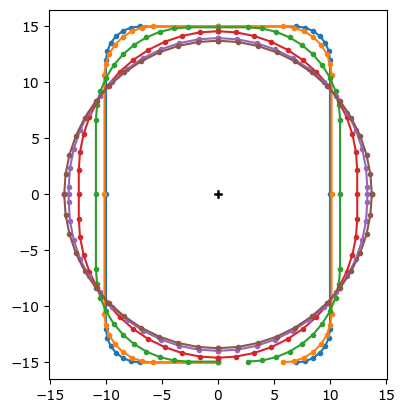

In [2]:
def transitionPiece(a,b,r):
    return mirrorTurtlePath([[a/2-r,0.0],[r*90*deg,90*deg],[b/2-r,0.0]])*2
a,b,r=20,30,3         
rn=(turtlePathLengthArea(transitionPiece(a,b,r))[1]/pi)**0.5 #circle with same area
print(f'{rn=}, {((a*b-r**2*(4-pi))/pi)**0.5=}')
n=6
from math import cos,pi
a0=1+0j
for i in range(n):
  alpha=0.5+0.5*cos(i/(n-1)*pi)
  r_=min(a/2,b/2,r+ (rn-r)*(1-alpha))
  a_,b_=2*r_+(a-2*r_)*alpha, 2*r_+(b-2*r_)*alpha
  turtlePath=transitionPiece(a_,b_,r_)
  L_,A_=turtlePathLengthArea(turtlePath)
  if i==0:
      L,A=L_,A_
  scale=(A/A_)**0.5 
  p0=0-1j*b_*scale/2
  px,headings=np.array(list(turtlePath2ComplexPoints(turtlePath,scale=scale,p0=p0,a0=a0,tol= 0.03,offs=0,return_heading=True))).transpose()
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()

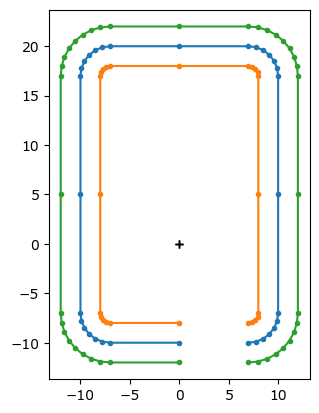

In [3]:
def transitionPiece(a,b,r):
    return mirrorTurtlePath([[a/2-r,0.0],[r*90*deg,90*deg],[b/2-r,0.0]])*2
a,b,r=20,30,3         
n=4
from math import cos,pi
a0=1+0j
for offs in (0,-2,2):
  turtlePath=transitionPiece(a,b,r)
  scale=1
  p0=0-1j*b_*scale/2
  px,headings=np.array(list(turtlePath2ComplexPoints(turtlePath,scale=scale,p0=p0,a0=a0,tol= 0.03,offs=offs,return_heading=True))).transpose()
  plt.plot(0,0,'k+')
  plt.plot(px.real,px.imag,'.-')
plt.gca().set_aspect('equal')
plt.show()

In [4]:
def fitBricks(minx,maxx,n):
  "This function returns a list of n (offset, width) tuples \n"
  "that evenly fill the space between xmin, and xmax. \n"
  w=maxx-minx
  dx=float(w)/n
  x=minx+dx/2
  result=[(x,abs(dx))]
  for i in range(n-1):
    x+=dx
    result.append((x,abs(dx)))
  if n>3:
    result=[result[1]]+[result[0]]+result[n-2:]+result[2:n-2]
  return result
#definition of "Brickwork" for a flange.
#For the flange to be flush with the wall of the tube, the tube wall has to be offset by
#1/2 its width so that the defined path is flush with the inside of the tube wall.
#The "Brickwork" is designed to be printed upside down as well, so it can be used in reverse
#for the top edge. The wall thickness of the tube itself shuold be about 1mm.
flangeBrickwork=[fitBricks(2.0,0.2,2)]+\
       [fitBricks(w2,0,n) for w2,n in ((4.4/2,3),(4.6/2,4))]+\
       [((cw/2,cw),(w2-ww/2,ww)) for w2,ww,cw in[ \
        (4.8/2,1.0,1.0),\
        (5.0/2,1.0,0.8),\
        (5.0/2,0.9,0.6)]+\
        [(5.0/2,0.9,0.5)]*2+[\
        (4.8/2,0.9,0.5),\
        (4.6/2,0.9,0.5),\
        (4.4/2,1.0,0.5),\
        (2.0,1.0,0.7)]\
        ]+\
        [fitBricks(1.8,0,2),\
         fitBricks(1.6,0,3),\
        fitBricks(1.4,0,2),\
        fitBricks(1.2,0,2)]+\
       [[((1.1-0.6*i/50.0)/2.0,1.1-0.6*i/50.0)] for i in range(1)]
      


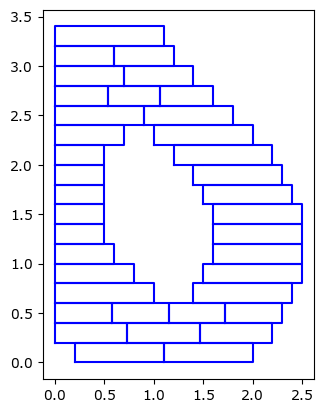

In [5]:
hl=0.2
for i,layer in enumerate(flangeBrickwork):
    y=i*hl
    if y>5.5:
      break
    for x,w in layer:
      plt.plot((x-w/2,x+w/2,x+w/2,x-w/2,x-w/2),(y,y,y+hl,y+hl,y),'b-')
plt.gca().set_aspect('equal')

In [6]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
import fullcontrol as fc
from math import cos, tau

In [12]:
from math import cos,pi
steps=[]
def transitionPiece(a,b,r):
    return mirrorTurtlePath([[a/2-r,0.0],[r*90*deg,90*deg],[b/2-r,0.0]])*2
a,b,r=20,30,3         

turtlePath=transitionPiece(a,b,r)
A=turtlePathLengthArea(turtlePath)[1]
rn=(A/pi)**0.5 #circle with same area
hl=0.2
w=1.0 #wall thickness
nwipe=5
nskip=5
nskirt=2
skirtoffs=3.0
jt=0 

#print the bottom flange
p0=0-1j*b/2
a0=1+0j
scale=1.0
tol=0.03
z=0
for i,layer in enumerate(flangeBrickwork):
    z+=hl
    if i==0:
      layer=[(skirtoffs-(0.6*(i-nskirt)),0.7) for i in range(nskirt)]+layer
    for offs,w in layer:
      path=list(turtlePath2ComplexPoints(turtlePath,p0=p0,a0=a0,tol=tol,scale=scale,offs=offs))
      n=len(path)
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=hl,width=w))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
          
#print the transition piece in spiral mode
zb=z
zt=zb+30.0
ew=w
dwdj=0.0 #constant wall thickness
old_eh=-1
old_ew=-1
steps.append(fc.Extruder(on=False))

while  z<(zt+hl):
  #re-calculate the path once for each layer
  alpha=0.5+0.5*cos((z-zb)/(zt-zb)*pi)
  r_=min(a/2,b/2,r+ (rn-r)*(1-alpha))
  a_,b_=2*r_+(a-2*r_)*alpha, 2*r_+(b-2*r_)*alpha
  turtlePath=transitionPiece(a_,b_,r_)
  L_,A_=turtlePathLengthArea(turtlePath)
  scale=(A/A_)**0.5 
  p0=0-1j*b_*scale/2
  dzdj=hl/n
  n_new=0
  for p in turtlePath2ComplexPoints(turtlePath,scale=scale,p0=p0,a0=a0,tol= 0.03,offs=w/2):
      n_new+=1
      z+=dzdj#this should add up to about hl for one complete path
      ew-=dwdj#does not change, since dwdj is zero for constant wall thickness
      if ((zt-(z-hl))/hl)<1e-2:
          break
      eh=min(z-zb,zt-(z-hl),hl)
      if eh<1e-4:
          print(f'{z=}, {zt=}, {z-hl=}, {eh=}')
      if (abs(eh-old_eh)/hl)>0.01 or abs(ew-old_ew)>0.005:
       # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
        steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=w))
        old_eh=eh
        old_w=w
      steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
      steps.append(fc.Extruder(on=True))#switch extruder on after moving to the first point
  n=n_new #n changes slightly as the path is recalculated

#print the top flange
turtlePath=[(2*pi*rn,2*pi)] #top path
scale=1
p0=0-1j*rn
a0=1+0j
z=zt
for i,layer in enumerate(reversed(flangeBrickwork)):
    z+=hl
    for offs,w in layer:
      path=list(turtlePath2ComplexPoints(turtlePath,p0=p0,a0=a0,tol=tol,scale=scale,offs=offs))
      n=len(path)
      steps.append(fc.Extruder(on=False))
      steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=hl,width=w))
      jt=jt%n
      p=path[jt]
      steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
      for _ in range(nskip):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=True))
      for _ in range(n):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))
      steps.append(fc.Extruder(on=False))
      for _ in range(nwipe):
        jt=(jt+1)%n
        p=path[jt]
        steps.append(fc.Point(x=p.real,y=p.imag,z=z))

steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100.0, y=100.0, z=0.0*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)

p0=-15j


<Figure size 640x480 with 0 Axes>

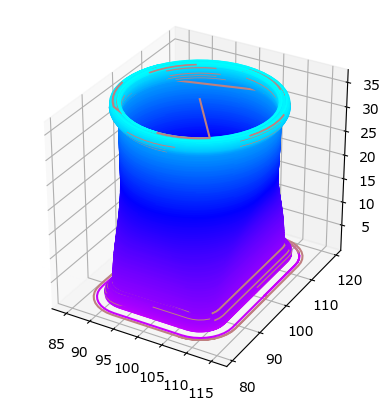

In [8]:
EW=1.0
EH=0.2
fc.transform(steps, 'plot', fc.PlotControls(style="line",color_type='print_sequence',raw_data=False, initialization_data={'extrusion_width': EW, 'extrusion_height': EH}));
#import matplotlib.pyplot as plt
#plt.gca().view_init(elev=30, azim=10, roll=0)

In [9]:
#design parameters

design_name = 'transition spool piece'
nozzle_temp = 220.0
bed_temp = 120.0
print_speed = 10.0*60
fan_percent = 0
EH = 0.2    # extrusion heigth
EW = 0.5    # extrusion width
printer_name = 'generic'
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)

In [10]:
flangeBrickwork

[[(1.55, 0.9), (0.65, 0.9)],
 [(1.8333333333333335, 0.7333333333333334),
  (1.1, 0.7333333333333334),
  (0.3666666666666667, 0.7333333333333334)],
 [(1.4374999999999998, 0.575),
  (2.0124999999999997, 0.575),
  (0.8624999999999998, 0.575),
  (0.28749999999999987, 0.575)],
 ((0.5, 1.0), (1.9, 1.0)),
 ((0.4, 0.8), (2.0, 1.0)),
 ((0.3, 0.6), (2.05, 0.9)),
 ((0.25, 0.5), (2.05, 0.9)),
 ((0.25, 0.5), (2.05, 0.9)),
 ((0.25, 0.5), (1.95, 0.9)),
 ((0.25, 0.5), (1.8499999999999999, 0.9)),
 ((0.25, 0.5), (1.7000000000000002, 1.0)),
 ((0.35, 0.7), (1.5, 1.0)),
 [(1.35, 0.9), (0.45000000000000007, 0.9)],
 [(1.3333333333333335, 0.5333333333333333),
  (0.8000000000000002, 0.5333333333333333),
  (0.26666666666666683, 0.5333333333333333)],
 [(1.0499999999999998, 0.7), (0.34999999999999987, 0.7)],
 [(0.8999999999999999, 0.6), (0.29999999999999993, 0.6)],
 [(0.55, 1.1)]]

In [11]:
list(reversed(flangeBrickwork))

[[(0.55, 1.1)],
 [(0.8999999999999999, 0.6), (0.29999999999999993, 0.6)],
 [(1.0499999999999998, 0.7), (0.34999999999999987, 0.7)],
 [(1.3333333333333335, 0.5333333333333333),
  (0.8000000000000002, 0.5333333333333333),
  (0.26666666666666683, 0.5333333333333333)],
 [(1.35, 0.9), (0.45000000000000007, 0.9)],
 ((0.35, 0.7), (1.5, 1.0)),
 ((0.25, 0.5), (1.7000000000000002, 1.0)),
 ((0.25, 0.5), (1.8499999999999999, 0.9)),
 ((0.25, 0.5), (1.95, 0.9)),
 ((0.25, 0.5), (2.05, 0.9)),
 ((0.25, 0.5), (2.05, 0.9)),
 ((0.3, 0.6), (2.05, 0.9)),
 ((0.4, 0.8), (2.0, 1.0)),
 ((0.5, 1.0), (1.9, 1.0)),
 [(1.4374999999999998, 0.575),
  (2.0124999999999997, 0.575),
  (0.8624999999999998, 0.575),
  (0.28749999999999987, 0.575)],
 [(1.8333333333333335, 0.7333333333333334),
  (1.1, 0.7333333333333334),
  (0.3666666666666667, 0.7333333333333334)],
 [(1.55, 0.9), (0.65, 0.9)]]